In [1]:
import tensorflow as tf
import librosa
import random
import larq as lq
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import datetime

print("TensorFlow version: ", tf.__version__)
tf.config.list_physical_devices()


TensorFlow version:  2.11.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#Dataset Path

DATASET_PATH = "./speech_commands_v0.02/"

data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)


Commands: ['right' 'cat' 'dog' 'no' 'left' 'stop' 'zero' 'yes']


In [3]:
#Load audio files and split them into train, validation and test sets.

from tensorflow.python.data.ops.dataset_ops import BatchDataset
train_ds: BatchDataset
val_ds: BatchDataset

batch_size = 32
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    output_sequence_length=16000,
    seed=123,
    subset="both",
    label_mode="categorical",
    shuffle=True)

Found 27646 files belonging to 8 classes.
Using 22117 files for training.
Using 5529 files for validation.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-17 13:40:31.271995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 13:40:31.272019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#Squeeze the audio to remove the last dimension

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

label_names = train_ds.class_names

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE, deterministic=True)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE, deterministic=True)

In [5]:
#Add noise to audio

#Load noise files
pink_noise_file = './_background_noise_/pink_noise.wav'
white_noise_file = './_background_noise_/white_noise.wav'

pink_noise_audio, _ = librosa.load(pink_noise_file, sr=16000)
white_noise_audio, _ = librosa.load(white_noise_file, sr=16000)

# Convert to tensors
white_noise_tensor = tf.convert_to_tensor(white_noise_audio, dtype=tf.float32)
pink_noise_tensor = tf.convert_to_tensor(pink_noise_audio, dtype=tf.float32)

# Add noise to audio
def add_noises(audio_tensor, noise_types=['pink'], noise_probs=[1], noise_levels=[0.01]):
    for noise_type, noise_prob, noise_level in zip(noise_types, noise_probs, noise_levels):
        if random.random() < noise_prob:
            if noise_type == 'white':
                noise_tensor = white_noise_tensor
            elif noise_type == 'pink':
                noise_tensor = pink_noise_tensor

            batch_size, audio_len = tf.shape(audio_tensor)[0], tf.shape(audio_tensor)[1]
            noise_len = int(tf.shape(noise_tensor)[0])
            start = tf.random.uniform((batch_size,), 0, noise_len - audio_len, dtype=tf.int32)
            indices = tf.expand_dims(tf.range(batch_size), axis=1)
            starts = tf.concat([indices, tf.expand_dims(start, axis=1)], axis=1)
            noise = tf.map_fn(lambda x: tf.slice(noise_tensor, [x[1]], [audio_len]), starts, dtype=tf.float32)
            audio_tensor = audio_tensor + noise_level * noise
    return audio_tensor

In [6]:
#Time shift

def time_shift(audio_tensor, shift_range=0.1):
    batch_size, audio_len = tf.shape(audio_tensor)[0], tf.shape(audio_tensor)[1]
    shift_amount = tf.cast(tf.cast(audio_len, tf.float32) * shift_range, tf.int32)
    shift = tf.random.uniform((batch_size,), minval=-shift_amount, maxval=shift_amount, dtype=tf.int32)

    def shift_audio(x):
        audio, delta = x
        paddings = tf.cond(
            delta < 0,
            lambda: ((-delta, 0),),
            lambda: ((0, delta),)
        )
        return tf.pad(tf.slice(audio, [tf.math.maximum(0, delta)], [audio_len - tf.math.abs(delta)]), paddings)

    shifted_audio = tf.map_fn(shift_audio, (audio_tensor, shift), dtype=tf.float32)
    return shifted_audio

In [7]:
# Pitch shift

def pitch_shift(audio_tensor, pitch_range=(0.3, 0.3), sample_rate=16000):
    def shift_pitch(x):
        audio = x.numpy()
        factor = np.random.uniform(pitch_range[0], pitch_range[1])
        n_bins = 12  # You can adjust this value based on your requirements
        shifted_audio = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=factor, bins_per_octave=n_bins)
        return tf.convert_to_tensor(shifted_audio, dtype=tf.float32)

    return tf.py_function(shift_pitch, [audio_tensor], tf.float32)


In [8]:
# Preprocess function
def preprocess_audio(audio, label, noise_colors=['pink'], noise_probs=[1], noise_levels=[0.01],
                     shift_range=0.1,
                     pitch_range=(-1, 1)):
    audio = time_shift(audio, shift_range)
    audio = add_noises(audio, noise_colors, noise_probs, noise_levels)
    audio = pitch_shift(audio, pitch_range)
    return audio, label

In [9]:
#Mapping the preprocessing function to the train and validation datasets

noise_colors = ['pink', 'white']
noise_probs = [0.5, 0.5]
noise_levels = [0.01, 0.01]
shift_range = 0.1
pitch_range = (-1, 1)

# Apply the preprocessing function to your train_ds and val_ds

train_ds = train_ds.map(lambda audio, label: preprocess_audio(audio, label, noise_colors, noise_probs, noise_levels, shift_range, pitch_range), tf.data.AUTOTUNE, deterministic=True)
val_ds = val_ds.map(lambda audio, label: preprocess_audio(audio, label, noise_colors, noise_probs, noise_levels, shift_range, pitch_range), tf.data.AUTOTUNE, deterministic=True)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


In [10]:
with tf.device('CPU: 0'):
    random_batch = random.choice(list(train_ds))
    random_audio_data, _ = random_batch
    random_audio_data = random_audio_data.numpy()

2023-05-17 13:40:33.304088: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
#Play a random audio sample

from IPython.display import Audio

random_sample_index = random.randint(0, random_audio_data.shape[0] - 1)
random_sample = random_audio_data[random_sample_index]
audio_player = Audio(random_sample, rate=16000)

audio_player

In [12]:
#Sharding the dataset

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [13]:
#Spectrogram and MFCC parameters

frame_length = 255 # 320
frame_step = 128 #160
fft_lenght = 256

frame_length = 320
frame_step = 160
fft_lenght = 512

mfcc = False # Set to False to use spectrogram

sample_rate = 16000
num_mel_bins = 40
num_mfccs = 13

normalization = False # Set to True to normalize the spectrogram
minval = 0
maxval = 1


In [14]:
#Converting the audio to spectrograms or MFCCs

sample_rate = 16000
num_mel_bins = 40
num_mfccs = 13

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=frame_length, frame_step=frame_step, fft_length=fft_lenght)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`)).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

import tensorflow as tf

def compute_mfccs(pcm, sample_rate, num_mel_bins, num_mfccs):
    # A 1024-point STFT with frames of 64 ms and 75% overlap.
    stfts = tf.signal.stft(pcm, frame_length=1024, frame_step=256)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = tf.shape(stfts)[-1]
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first num_mfccs.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    
    return mfccs



def get_mfcc(waveform, sample_rate, num_mel_bins, num_mfccs):
    # Compute MFCCs from the input waveform.
    mfccs = compute_mfccs(waveform, sample_rate, num_mel_bins, num_mfccs)

    # Add a `channels` dimension, so that the MFCCs can be used
    # as input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`)).
    mfccs = mfccs[..., tf.newaxis]

    return mfccs


def make_spec_ds(ds: tf.data.Dataset):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE,
      deterministic=True)

def make_mfcc_ds(ds: tf.data.Dataset):
    return ds.map(
        map_func=lambda audio, label: (get_mfcc(audio, sample_rate = sample_rate, num_mel_bins=num_mel_bins, num_mfccs=num_mfccs), label),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True)

if(mfcc):
    train_spectrogram_ds = make_mfcc_ds(train_ds)
    val_spectrogram_ds = make_mfcc_ds(val_ds)
    test_spectrogram_ds = make_mfcc_ds(test_ds)
else:
    train_spectrogram_ds = make_spec_ds(train_ds)
    val_spectrogram_ds = make_spec_ds(val_ds)
    test_spectrogram_ds = make_spec_ds(test_ds)

Shape of Spectrogram:  (32, 99, 257, 1)


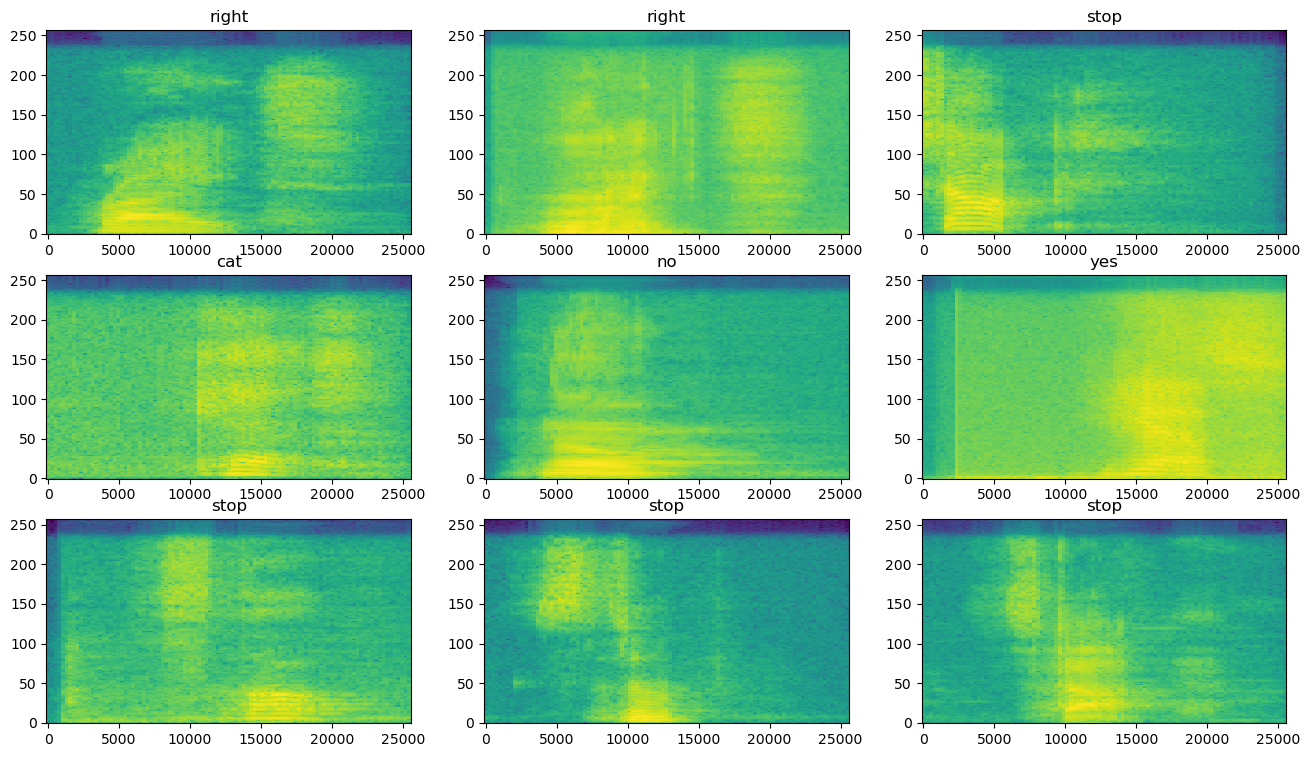

In [17]:
#Spectrogram plotting function

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  x = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  y = range(height)
  ax.pcolormesh(x, y, log_spec)

def plot_mfcc(mfcc, ax):
    if len(mfcc.shape) > 2:
        assert len(mfcc.shape) == 3
        mfcc = np.squeeze(mfcc, axis=-1)
    mfcc_data = np.swapaxes(mfcc, 0, 1)
    ax.imshow(mfcc_data, interpolation='nearest', cmap=plt.cm.coolwarm, origin='lower', aspect='auto')
    ax.set_title('MFCC')


for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

if(mfcc): print("Shape of MFCC: ", example_spectrograms.shape)
else: print("Shape of Spectrogram: ", example_spectrograms.shape)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    if(mfcc): plot_mfcc(example_spectrograms[i].numpy(), ax)
    else: plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy().argmax()])

plt.show()

In [18]:
#Normalization

def normalize_spectrogram(x, min_val = minval, max_val = maxval):
    min_x = tf.reduce_min(x, axis=[1, 2], keepdims=True)
    max_x = tf.reduce_max(x, axis=[1, 2], keepdims=True)
    normalized_x = (x - min_x) * (max_val - min_val) / (max_x - min_x) + min_val
    return normalized_x

if(normalization):
    train_spectrogram_ds = train_spectrogram_ds.map(lambda audio, label: (normalize_spectrogram(audio), label), tf.data.AUTOTUNE)
    val_spectrogram_ds = val_spectrogram_ds.map(lambda audio, label: (normalize_spectrogram(audio), label), tf.data.AUTOTUNE)
    test_spectrogram_ds = test_spectrogram_ds.map(lambda audio, label: (normalize_spectrogram(audio), label), tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print(input_shape)


(99, 257, 1)


In [19]:
#Custom quantization function

def create_custom_quant(levels, is_activation=True):
    @tf.custom_gradient
    def custom_quant(x):
        
        def grad(dy):
            if is_activation:
                return tf.where(tf.math.logical_and(x >= min(levels), x <= max(levels)), dy, 0)
            else:
                return dy
        
        def quant(x):
            levels_tensor = tf.constant(levels, dtype=tf.float32)
            distances = tf.abs(tf.expand_dims(x, -1) - levels_tensor)
            min_distance_indices = tf.argmin(distances, axis=-1)
            return tf.gather(levels_tensor, min_distance_indices)

        return quant(x), grad

    return custom_quant

In [20]:
#Custom Clip function

from keras.constraints import Constraint
import keras.backend as k

class CustomLevelClip(Constraint):
    def __init__(self, levels):
        self.min_value = min(levels)
        self.max_value = max(levels)

    def __call__(self, w):        
        return k.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}



In [21]:
#Custom quantization layer

from larq import quantizers

class CustomQuantizeLayer(tf.keras.layers.Layer):
    def __init__(self, quantizer, input_shape=None, **kwargs):
        if input_shape is not None:
            super(CustomQuantizeLayer, self).__init__(input_shape=input_shape, **kwargs)
        else:
            super(CustomQuantizeLayer, self).__init__(**kwargs)
        self.quantizer = quantizer

    def build(self, input_shape):
        super(CustomQuantizeLayer, self).build(input_shape)

    def call(self, inputs):
        return self.quantizer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "quantizer": self.quantizer,
            "input_shape": self.input_shape,
        })
        return config

In [53]:
#Custom quantization parameters

levels = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
levels.sort()
print("Custom quantizer levels: ", levels)

max_value = max(levels)
min_value = min(levels)
clip_value = max(abs(max_value), abs(min_value))

custom_constraint = CustomLevelClip(levels=levels)

kwargs_no_input_quant = dict(
    kernel_quantizer=create_custom_quant(levels=levels, is_activation=False),
    #kernel_constraint=lq.constraints.WeightClip(clip_value=clip_value),
    kernel_constraint=custom_constraint,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=min_value, maxval=max_value, seed=np.random.randint(0, 1000)),
    use_bias=False
)

#quantization of activations is done in a separate layer 
quantizer = lq.quantizers.DoReFa(k_bit=3, mode="activations")

#batch normalization arguments
kwargs_BN = dict(
    scale=True
)

dropout_rate = 0.15
dropout_rate_dense = 0.3

Custom quantizer levels:  [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]


In [54]:
#model definition

model = tf.keras.models.Sequential()

model.add(CustomQuantizeLayer(quantizer, input_shape=input_shape))
model.add(lq.layers.QuantConv2D(24, (9, 11), **kwargs_no_input_quant))
model.add(tf.keras.layers.MaxPooling2D(3, 3))
model.add(tf.keras.layers.BatchNormalization(**kwargs_BN))
#dropout
model.add(tf.keras.layers.Dropout(dropout_rate))


model.add(CustomQuantizeLayer(quantizer))
model.add(lq.layers.QuantConv2D(24, (5, 7), **kwargs_no_input_quant))
model.add(tf.keras.layers.MaxPooling2D((2, 3)))
model.add(tf.keras.layers.BatchNormalization(**kwargs_BN))
#dropout
model.add(tf.keras.layers.Dropout(dropout_rate))


model.add(CustomQuantizeLayer(quantizer))
model.add(lq.layers.QuantConv2D(24, (3, 5), **kwargs_no_input_quant))
model.add(tf.keras.layers.BatchNormalization(**kwargs_BN))
#dropout
model.add(tf.keras.layers.Dropout(dropout_rate))

#flatten
model.add(tf.keras.layers.Flatten())

model.add(CustomQuantizeLayer(quantizer))
model.add(lq.layers.QuantDense(len(label_names), **kwargs_no_input_quant))
model.add(tf.keras.layers.BatchNormalization(**kwargs_BN))
#dropout
model.add(tf.keras.layers.Dropout(dropout_rate_dense))
model.add(tf.keras.layers.Activation("softmax"))

#print lq model summary
#lq.models.summary(model, print_fn=print)
model.summary()

#print number of trainable and non-trainable parameters
print("Trainable parameters:", model.count_params())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_quantize_layer_108 (  (None, 99, 257, 1)       0         
 CustomQuantizeLayer)                                            
                                                                 
 quant_conv2d_81 (QuantConv2  (None, 91, 247, 24)      2376      
 D)                                                              
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 30, 82, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_108 (Ba  (None, 30, 82, 24)       96        
 tchNormalization)                                               
                                                                 
 dropout_108 (Dropout)       (None, 30, 82, 24)      

In [67]:
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

import keras.callbacks as callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

model.fit(train_spectrogram_ds,
          epochs=10,
          callbacks=[tensorboard_callback, earlystopping],
          validation_data=val_spectrogram_ds)

Epoch 1/10


2023-05-17 15:33:44.022792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


692/692 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7160

2023-05-17 15:35:15.985914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


692/692 [==============================] - 103s 146ms/step - loss: 0.6246 - accuracy: 0.7160 - val_loss: 0.3311 - val_accuracy: 0.8917
Epoch 2/10
692/692 [==============================] - 105s 151ms/step - loss: 0.6021 - accuracy: 0.7262 - val_loss: 0.3045 - val_accuracy: 0.9033
Epoch 3/10
692/692 [==============================] - 106s 152ms/step - loss: 0.6035 - accuracy: 0.7238 - val_loss: 0.3442 - val_accuracy: 0.8957
Epoch 4/10
692/692 [==============================] - 125s 180ms/step - loss: 0.5897 - accuracy: 0.7325 - val_loss: 0.3101 - val_accuracy: 0.9033
Epoch 5/10
692/692 [==============================] - 100s 143ms/step - loss: 0.5989 - accuracy: 0.7240 - val_loss: 0.3222 - val_accuracy: 0.9001
Epoch 6/10
692/692 [==============================] - 106s 153ms/step - loss: 0.5923 - accuracy: 0.7295 - val_loss: 0.2885 - val_accuracy: 0.9099
Epoch 7/10
692/692 [==============================] - 109s 156ms/step - loss: 0.5823 - accuracy: 0.7328 - val_loss: 0.3210 - val_accura

In [56]:
model.evaluate(test_spectrogram_ds)

87/87 [==============================] - 9s 93ms/step - loss: 0.4350 - accuracy: 0.8603


[0.43504956364631653, 0.8602808713912964]

In [ ]:
#Save model
with lq.context.quantized_scope(True):
    model.save("model91/6_classes/relu")  # save quant weights in SavedModel format
    weights = model.get_weights()  # get quant weights


In [ ]:
#Import saved model
from tensorflow.keras.models import load_model
import larq as lq

custom_objects = {
    "QuantConv2d": lq.layers.QuantConv2D,
    "QuantDense": lq.layers.QuantDense,
    "CustomQuantizer": create_custom_quant
}

with lq.context.quantized_scope(True):
    model = load_model("model93/6_classes", custom_objects=custom_objects)
    
model.summary()

In [57]:
#confusion matrix function
def get_true_and_predicted_labels(model, dataset):
    y_pred = []
    y_true = []

    for image_batch, label_batch in dataset:
        y_true.append(tf.argmax(label_batch, axis=-1))  # Convert one-hot encoded labels to class indices
        preds = model.predict(image_batch, verbose=0)
        y_pred.append(np.argmax(preds, axis=-1))

    correct_labels = tf.concat([item for item in y_true], axis=0)
    predicted_labels = tf.concat([item for item in y_pred], axis=0)

    return correct_labels, predicted_labels


from sklearn.metrics import ConfusionMatrixDisplay

def print_confusion_matrix(model, val_spectrogram_ds):
    correct_labels, predicted_labels = get_true_and_predicted_labels(model, val_spectrogram_ds)
    confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels).numpy()

     # Optionally, you can use ConfusionMatrixDisplay from scikit-learn to visualize the confusion matrix
    
    fig, ax = plt.subplots(figsize=(20, 20))
    display = ConfusionMatrixDisplay(confusion_mtx, display_labels=label_names)

    display.plot(xticks_rotation='vertical', ax=ax)
    plt.show()



2023-05-17 15:12:31.195580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


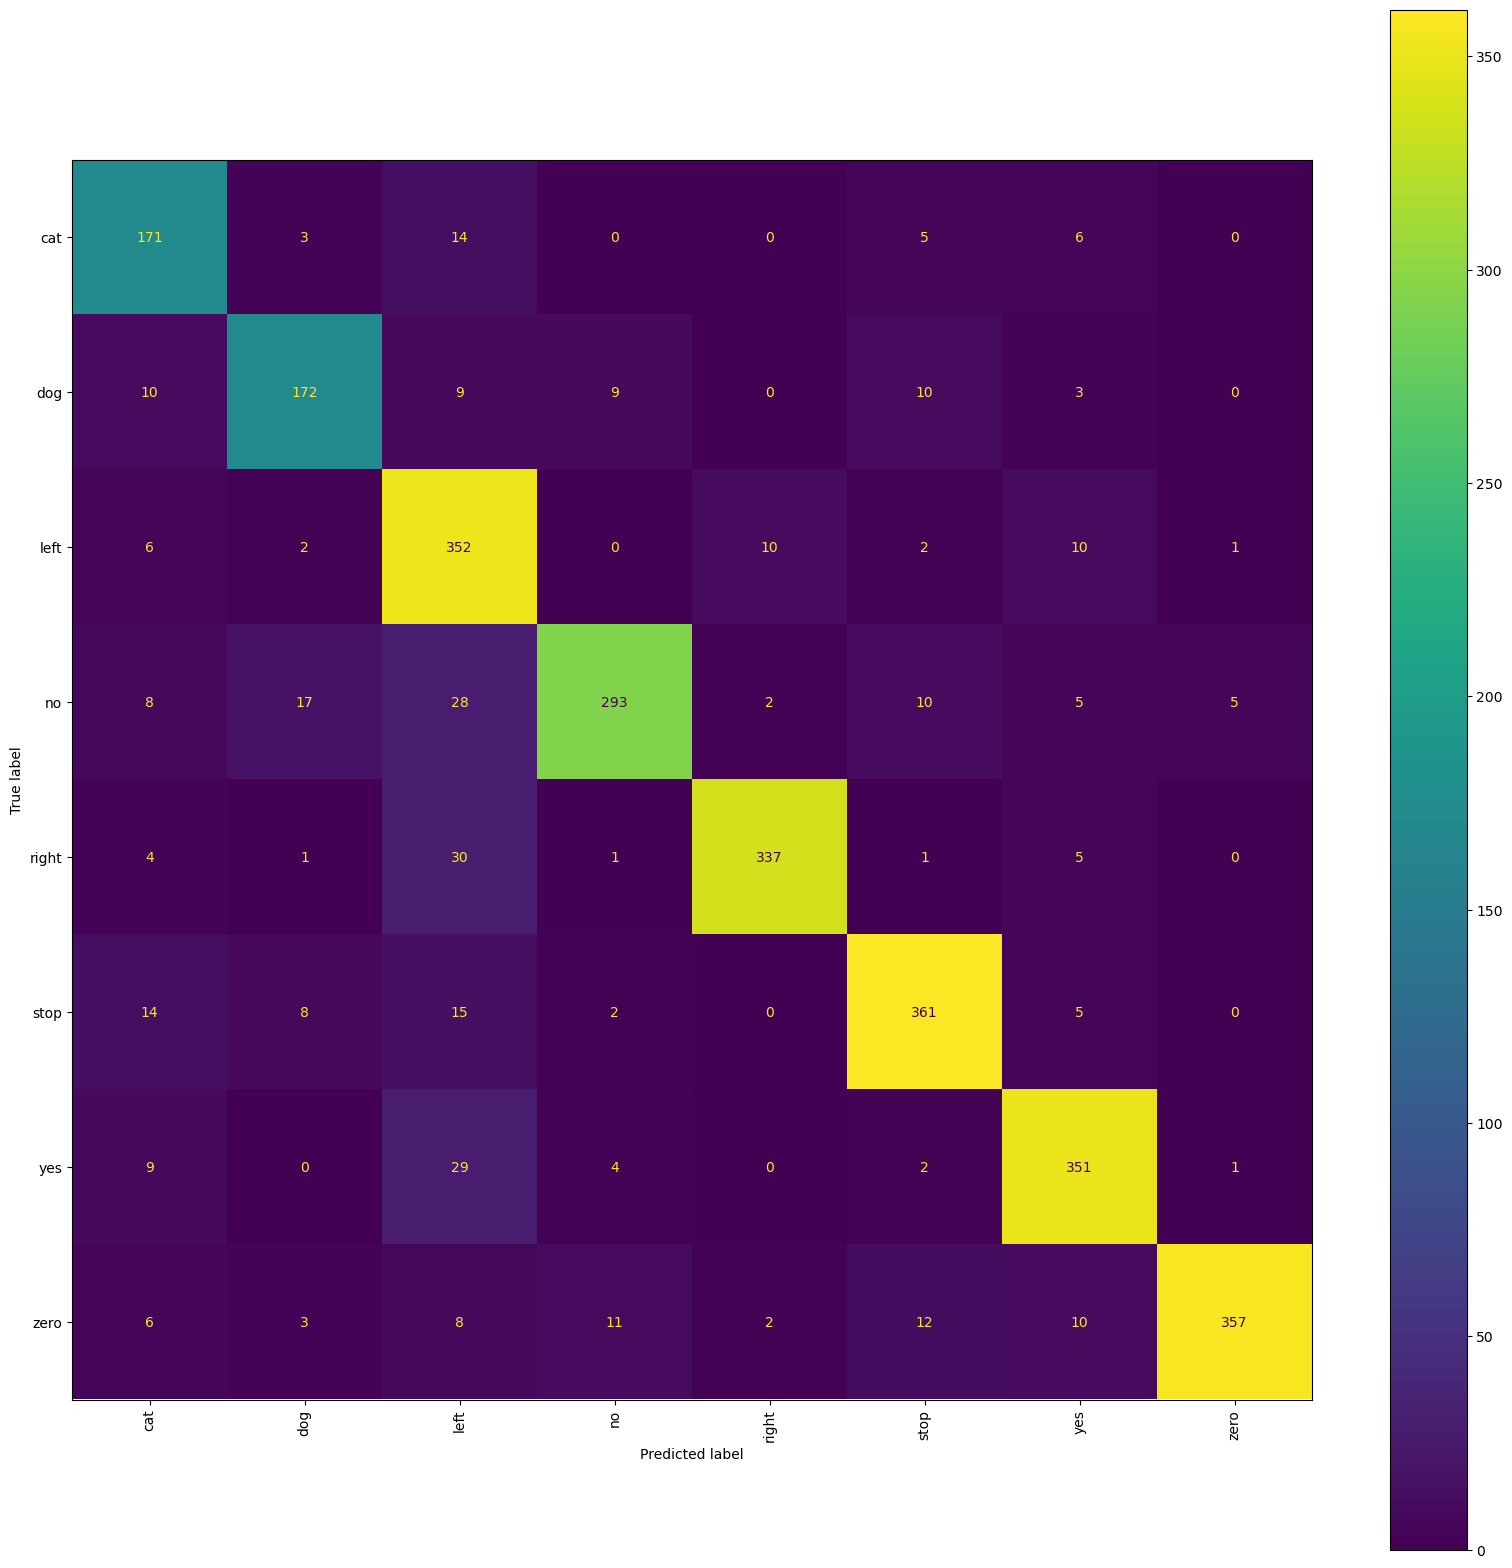

In [58]:
print_confusion_matrix(model, val_spectrogram_ds)

In [59]:
#function to get the output of a layer

def get_layer_output(model, layer_index, test_ds: tf.data.Dataset):

    # Create a new model with the specified layer's output
    layer_output_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)

    # Pass the input_data to the new model to get the output of the specified layer
    example, label = test_ds.rebatch(1).shuffle(len(test_ds)).take(1).as_numpy_iterator().next()    

    #convert label to string
    label = label_names[np.argmax(label)]

    #get layer output
    layer_output = layer_output_model.predict(example)

    return layer_output, label

In [60]:
#functions to plot feature maps

show_colorbar = True

def plot_feature_maps(model, layer_index, test_spectrogram_ds: tf.data.Dataset):

    #handle plotting of input
    if layer_index == -1:
        example, label = test_spectrogram_ds.rebatch(1).shuffle(len(test_spectrogram_ds)).take(1).as_numpy_iterator().next()
        label = label_names[np.argmax(label)]
        plot_conv_feature_maps(example, 1, layer_index, model, label)
        return

    feature_maps, label = get_layer_output(model, layer_index, test_spectrogram_ds)
    
    # Check the dimensions of the layer output
    #if("CustomQuantizeLayer" in str(type(model.layers[layer_index]))):
    #    print("Specified layers is a CustomQuantizeLayer. Cannot plot feature maps.")
    #    return
    if len(feature_maps.shape) == 4:  # Conv2D or MaxPooling2D layers
        num_feature_maps = feature_maps.shape[-1]
        plot_conv_feature_maps(feature_maps, num_feature_maps, layer_index, model, label)
        
    elif len(feature_maps.shape) == 2:  # Dense layer
        plot_dense_feature_maps(feature_maps, layer_index, model, label)
        
    else:
        print(f"Layer {layer_index} has an unsupported output shape. Cannot plot feature maps.")


import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_conv_feature_maps(feature_maps, num_feature_maps, layer_index, model, label, show_colorbar=show_colorbar):
    # Create a grid of subplots
    if num_feature_maps == 1:
        num_cols = 1
        num_rows = 1
        figsize = (10, 7)  # Rectangular dimensions for single-channel input spectrogram
    else:
        num_cols = 4
        num_rows = num_feature_maps // num_cols + (num_feature_maps % num_cols > 0)
        figsize = (15, 15)  # Square dimensions for multi-channel feature maps

    # Set up the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Set title of the figure as the layer name and index
    if (layer_index != -1) & (layer_index != 0): fig.suptitle(f'Feature Maps of Layer {layer_index}: {model.layers[layer_index].name}\nOutput shape {feature_maps.shape}\nLabel: {label}')
    elif layer_index == -1 : fig.suptitle(f'Input Spectrogram\nLabel: {label}')
    elif layer_index == 0 : fig.suptitle(f'Quantized Input Spectrogram\nLabel: {label}')
    
    # Plot each feature map
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_feature_maps:
                if num_feature_maps == 1:
                    ax = axes
                else:
                    ax = axes[i, j]
                img = ax.imshow(feature_maps[0, :, :, idx], cmap='gray')
                if (layer_index != -1) & (layer_index != 0): ax.set_title(f'Feature Map {idx}')
                ax.axis('off')
                
                # Add a colorbar legend to the right of each image if show_colorbar is True
                if show_colorbar:
                    cbar = fig.colorbar(img, ax=ax)
                    cbar.ax.tick_params(labelsize=8)

    # Display the plot
    plt.show()



def plot_dense_feature_maps(feature_maps, layer_index, model, label):
    # Reshape the feature maps to a 1D array
    reshaped_feature_maps = np.reshape(feature_maps, (-1,))

    # Set up the figure
    fig, ax = plt.subplots(figsize=(15, 5))

    # Set title of the figure as the layer name and index
    fig.suptitle(f'Feature Maps of Layer {layer_index}: {model.layers[layer_index].name}\nOutput shape {feature_maps.shape}\nLabel: {label}')

    # Plot the feature maps as a bar plot
    ax.bar(range(len(reshaped_feature_maps)), reshaped_feature_maps)
    ax.set_xlabel('Feature Map Index')
    ax.set_ylabel('Value')
    #set x ticks to be label names if layer is last one 
    if(layer_index == len(model.layers) - 1):
        ax.set_xticks(np.arange(len(reshaped_feature_maps)), label_names)
        plt.xticks(rotation=90)

    # Display the plot
    plt.show()



1/1 [==============================] - 0s 52ms/step


2023-05-17 15:14:15.869960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


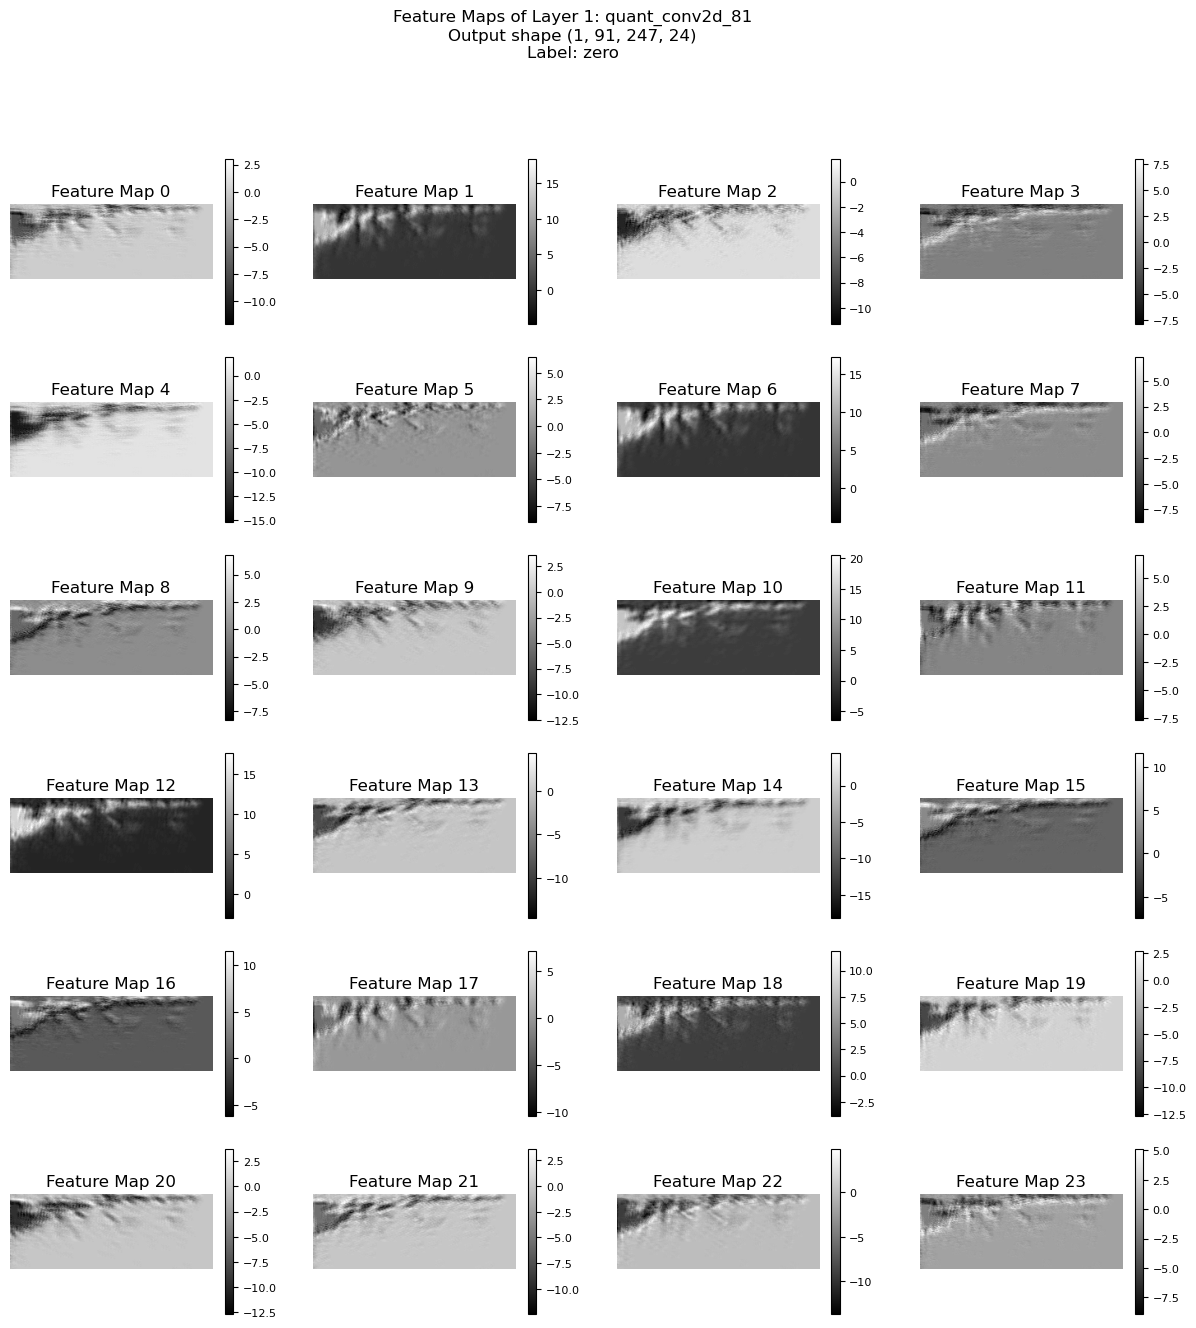

In [65]:
tf.keras.utils.set_random_seed(399)
plot_feature_maps(model, 1, test_spectrogram_ds)


In [ ]:
#print model quantized weights for all layers
with lq.context.quantized_scope(True):
    for layer in model.layers:
            print(layer.name)
            print(layer.get_weights())



In [ ]:
#Function to print all layers activations

def print_layers_activations(model: tf.keras.Sequential, test_ds: tf.data.Dataset, mode, index=None):
    
    if mode == "all":
        for i in range(model.layers.__len__()):
            print(f"Layer {i}: {model.layers[i].name}")
            feature_maps, label = get_layer_output(model, i, test_ds)
            print(feature_maps)
            print(feature_maps.shape)
            print("\n")
    elif mode == "single":
        if index == -1:
            example, label = test_ds.rebatch(1).shuffle(len(test_ds)).take(1).as_numpy_iterator().next() 
            print("Spectrogram with label " + label_names[np.argmax(label)])
            print("\n")
            print(example)
            print(example.shape)
            return
        print(f"Layer {index}: {model.layers[index].name}")
        feature_maps, label = get_layer_output(model, index, test_ds)
        np.set_printoptions(threshold=np.inf)
        print(feature_maps)
        print(feature_maps.shape)
        print("\n")
    print(label_names[np.argmax(label)])

In [ ]:
np.set_printoptions(precision=8, suppress=True)
print_layers_activations(model, test_spectrogram_ds, "single", 0)